# MMA Data Analysis

In [140]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
from pprint import pprint
# Visualization
import seaborn as sns
plt.style.use('ggplot')

In [141]:
#SciKit Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [142]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Columns: 895 entries, BPrev to winner
dtypes: float64(873), int64(13), object(9)
memory usage: 10.1+ MB


In [143]:
fight_features = set()
fighter_features = set()
general_features = set()

for c in df.columns:
    if (c[1:8] == '__Round'):
        fight_features.add(c[9:])
    elif c[0] == 'B' or c[0] == 'R':
        fighter_features.add(c[1:])
    else:
        general_features.add(c)
print(len(fight_features)) # features of each round
print(len(fighter_features)) # features of each fighter
print(len(general_features)) # features of each fight
pprint(fight_features)
pprint(fighter_features)
pprint(general_features)

87
9
7
{'_Grappling_Reversals_Landed',
 '_Grappling_Standups_Landed',
 '_Grappling_Submissions_Attempts',
 '_Grappling_Takedowns_Attempts',
 '_Grappling_Takedowns_Landed',
 '_Strikes_Body Significant Strikes_Attempts',
 '_Strikes_Body Significant Strikes_Landed',
 '_Strikes_Body Total Strikes_Attempts',
 '_Strikes_Body Total Strikes_Landed',
 '_Strikes_Clinch Body Strikes_Attempts',
 '_Strikes_Clinch Body Strikes_Landed',
 '_Strikes_Clinch Head Strikes_Attempts',
 '_Strikes_Clinch Head Strikes_Landed',
 '_Strikes_Clinch Leg Strikes_Attempts',
 '_Strikes_Clinch Leg Strikes_Landed',
 '_Strikes_Clinch Significant Kicks_Attempts',
 '_Strikes_Clinch Significant Kicks_Landed',
 '_Strikes_Clinch Significant Punches_Attempts',
 '_Strikes_Clinch Significant Punches_Landed',
 '_Strikes_Clinch Significant Strikes_Attempts',
 '_Strikes_Clinch Significant Strikes_Landed',
 '_Strikes_Clinch Total Strikes_Attempts',
 '_Strikes_Clinch Total Strikes_Landed',
 '_Strikes_Distance Body Kicks_Attempts',
 '

In [159]:
team_map = {'red': 'R', 'blue': 'B'}

def collapse_fighter(fighter_dict, team, row):
    assert(type(fighter_dict) == dict)
    assert(team == 'R' or team == 'B')
    name = row[team+'_Name']
    n = fighter_dict.get(name, dict())
    n['count_'] = n.get('count_', 0) + 1
    n['Id'] = n.get(id, row['{}_ID'.format(team)])
    tmp = dict()
    rounds = row['Max_round']
    for round_ in range(1, rounds+1):
        for f in fight_features:
            tmp[f] = tmp.get(f, 0.) + row['{}__Round{}{}'.format(team, round_, f)]
            #print(f, row["{}__Round{}{}".format(team, round_, f)])
    n['Streak'] = (n.get('Streak', 0) + row['{}Streak'.format(team)])
    if 'Age' not in n:
        n['Age'] = row["{}_Age".format(team)]
    if 'Height' not in n:
        n['Height'] = row["{}_Height".format(team)]
    if 'Weight' not in n:
        n['Weight'] = row["{}_Weight".format(team)]
    if team_map.get(row['winner'], "") == team:
        n['wins'] = n.get('wins', 0) + 1
    for f in fight_features:
        tmp[f] = tmp[f]/rounds
        n[f] = n.get(f, 0) + tmp[f]
    fighter_dict[name] = n

In [160]:
ndf = df
ndf = ndf.fillna(0)
fighters = dict()

for idx, row in ndf.iterrows():
    collapse_fighter(fighters, 'R', row)
    collapse_fighter(fighters, 'B', row)

In [161]:
print(len(fighters),'fighters')
for fighter in fighters:
    fd = fighters[fighter]
    count = fd['count_']
    fd['Id'] = int(fd['Id'])
    for f in fight_features:
        fd[f] = fd[f]/count
    fd['Streak'] = fd['Streak']/count
    fd['wins'] = fd.get('wins', 0)
    fd['win_prob'] = fd['wins']/count
    fighters[fighter] = fd        

852 fighters


In [162]:
fighterdf = pd.DataFrame(fighters).T
fighterdf.sort_values('wins', ascending=False)[:10]

,Age,Height,Id,Streak,Weight,_Grappling_Reversals_Landed,_Grappling_Standups_Landed,_Grappling_Submissions_Attempts,_Grappling_Takedowns_Attempts,_Grappling_Takedowns_Landed,...,_TIP_Guard Control Time,_TIP_Half Guard Control Time,_TIP_Misc. Ground Control Time,_TIP_Mount Control Time,_TIP_Neutral Time,_TIP_Side Control Time,_TIP_Standing Time,count_,win_prob,wins
Donald Cerrone,33.0,185.0,1076.0,2.923077,77.0,0.000000,0.235897,1.102564,3.400000,0.928205,...,8.646154,29.810256,2.784615,25.605128,785.205128,2.738462,825.851282,13.0,0.846154,11.0
Max Holloway,25.0,180.0,1936.0,4.500000,65.0,0.000000,0.480000,0.600000,0.433333,0.193333,...,2.333333,8.160000,46.526667,22.960000,545.553333,0.180000,631.000000,10.0,1.000000,10.0
Neil Magny,29.0,190.0,2047.0,2.583333,77.0,0.000000,2.816667,0.155556,9.361111,4.127778,...,0.211111,48.788889,11.311111,73.911111,630.688889,3.333333,869.911111,12.0,0.833333,10.0
Beneil Dariush,27.0,177.0,2168.0,1.727273,70.0,0.000000,0.272727,1.060606,4.545455,1.696970,...,35.030303,56.666667,4.848485,59.606061,408.212121,8.818182,524.818182,11.0,0.727273,8.0
Derrick Lewis,32.0,190.0,2082.0,1.400000,118.0,0.000000,1.620000,0.000000,1.553333,0.606667,...,7.800000,28.840000,20.693333,38.700000,118.286667,5.540000,199.373333,10.0,0.800000,8.0
Tony Ferguson,33.0,180.0,1815.0,3.500000,70.0,0.108333,1.083333,1.358333,1.133333,0.616667,...,0.000000,0.733333,30.683333,21.283333,297.533333,4.075000,323.025000,8.0,1.000000,8.0
Francisco Trinaldo,38.0,175.0,1997.0,2.900000,70.0,0.000000,1.166667,0.266667,2.933333,1.166667,...,113.566667,6.533333,0.000000,21.700000,686.833333,2.433333,816.433333,10.0,0.800000,8.0
Gegard Mousasi,31.0,187.0,786.0,1.272727,84.0,0.054545,0.230303,0.636364,1.606061,1.109091,...,61.515152,70.618182,0.000000,48.648485,493.018182,26.830303,552.442424,11.0,0.727273,8.0
Kelvin Gastelum,25.0,175.0,2070.0,1.111111,84.0,0.044444,0.814815,0.192593,1.429630,0.696296,...,27.740741,3.200000,14.355556,23.874074,616.614815,2.622222,719.459259,9.0,0.777778,7.0
Jorge Masvidal,32.0,180.0,1272.0,1.000000,77.0,0.000000,1.366667,0.706667,2.713333,1.400000,...,65.253333,26.033333,66.166667,8.253333,1185.860000,0.000000,940.966667,10.0,0.700000,7.0


### Correlation of features with winning probability

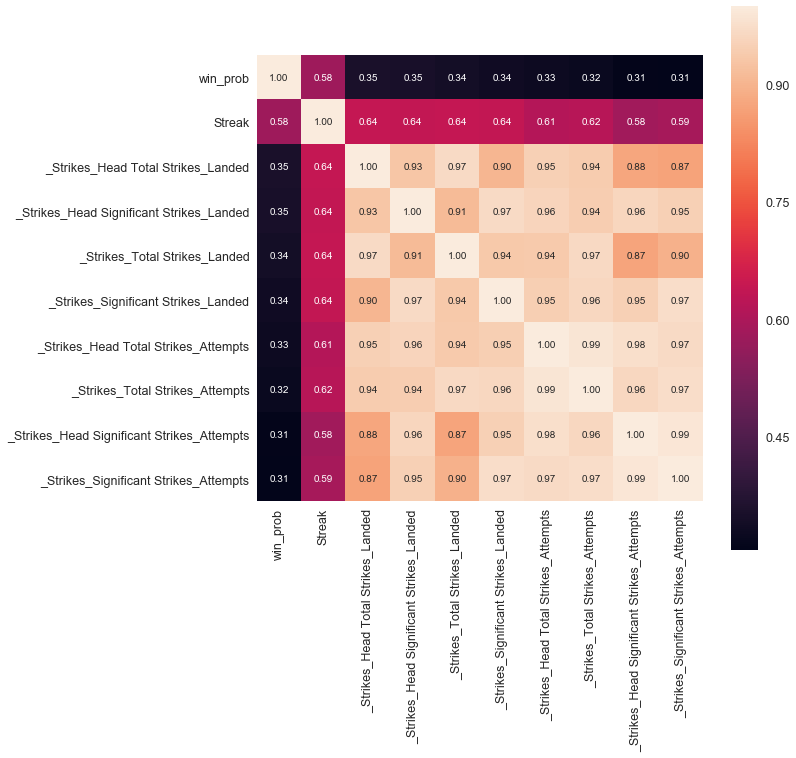

In [163]:
fighter_drop_df = fighterdf.drop(['wins','count_',],axis=1)
fig, ax = plt.subplots(figsize=(10,10))  
k = 10
corrmat = fighter_drop_df.corr()
cols = corrmat.nlargest(k, 'win_prob')['win_prob'].index
cm = np.corrcoef(fighter_drop_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Data Visualizations

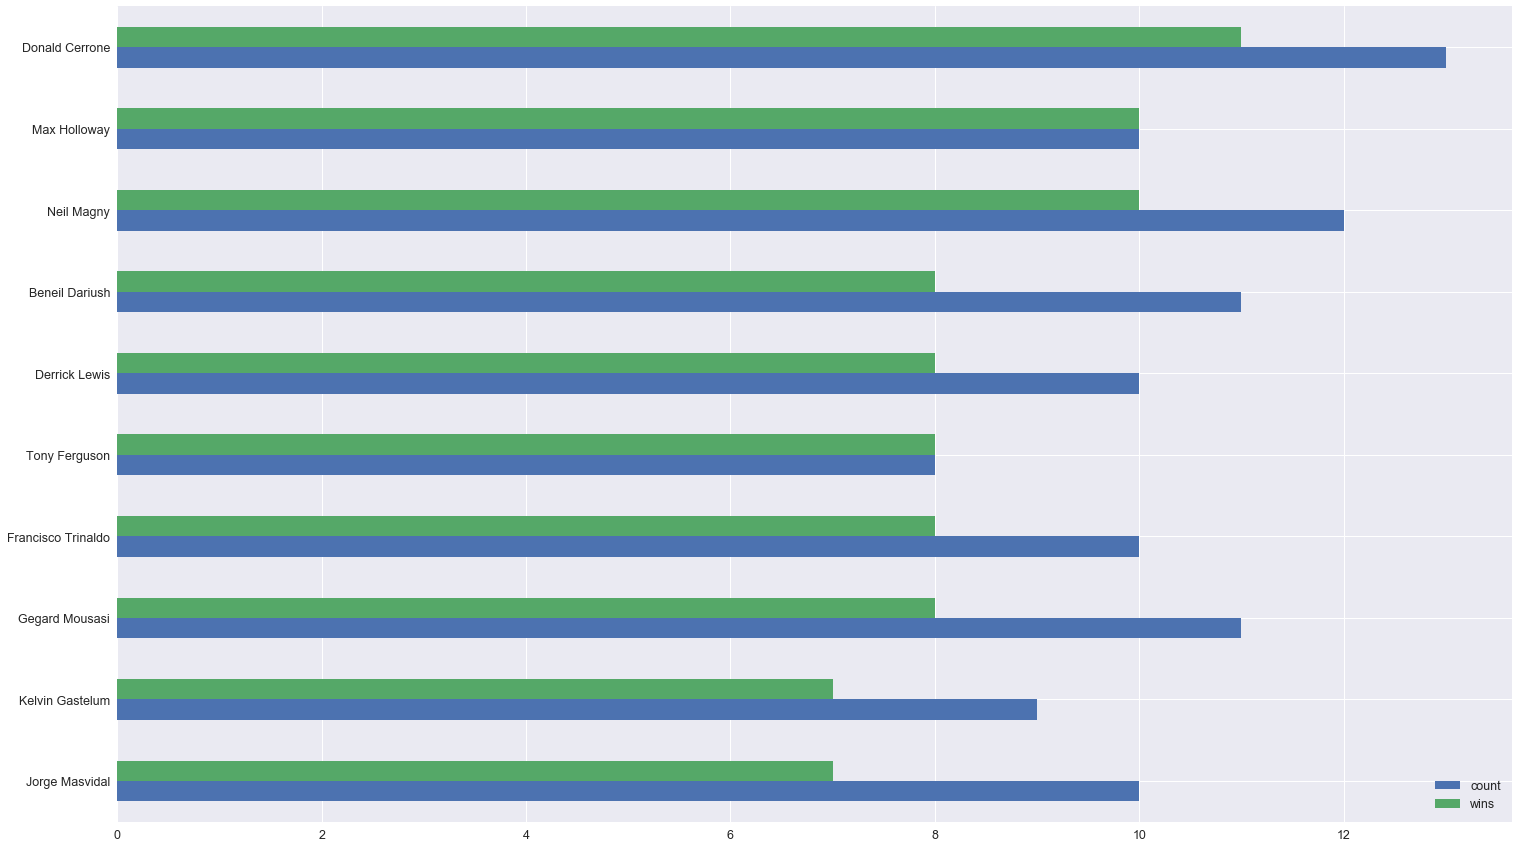

In [164]:
wins_fighterdf = pd.DataFrame(data={'count': fighterdf['count_'], 'wins' : fighterdf['wins'] }, index=fighterdf.index)
wins_fighterdf = wins_fighterdf.sort_values(by="wins",ascending=False)
wins_fighterdf
wins_fighterdf[:10][::-1].plot(kind='barh',stacked=False,figsize=(25,15)) #Top 50

In [165]:
fighterdf.describe()

,Age,Height,Id,Streak,Weight,_Grappling_Reversals_Landed,_Grappling_Standups_Landed,_Grappling_Submissions_Attempts,_Grappling_Takedowns_Attempts,_Grappling_Takedowns_Landed,...,_TIP_Guard Control Time,_TIP_Half Guard Control Time,_TIP_Misc. Ground Control Time,_TIP_Mount Control Time,_TIP_Neutral Time,_TIP_Side Control Time,_TIP_Standing Time,count_,win_prob,wins
count,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,...,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000
mean,30.825117,177.066901,1989.057512,0.452749,73.596244,0.014706,0.294012,0.155720,1.227235,0.463506,...,11.117489,7.098963,2.844407,11.264115,137.313091,2.866041,168.725214,3.467136,0.418108,1.703052
std,4.642943,10.583404,706.851087,0.567893,15.047091,0.052621,0.444582,0.293815,1.743745,0.699099,...,36.150793,14.761098,7.855100,27.396368,154.009947,7.215000,176.593940,2.176706,0.337501,1.772579
min,0.000000,0.000000,129.000000,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,172.000000,1743.500000,0.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,12.277778,0.000000,15.166667,2.000000,0.000000,0.000000
50%,31.000000,177.000000,2176.500000,0.333333,70.000000,0.000000,0.111111,0.000000,0.500000,0.166667,...,0.126984,0.000000,0.000000,2.833333,92.000000,0.000000,122.777778,3.000000,0.428571,1.000000
75%,34.000000,182.000000,2438.000000,0.600000,77.000000,0.000000,0.444444,0.222222,1.666667,0.666667,...,11.027778,6.863889,0.400000,14.000000,210.680952,1.756944,262.351190,5.000000,0.666667,3.000000
max,46.000000,213.000000,2882.000000,4.500000,120.000000,0.629630,3.444444,2.333333,9.975000,5.074074,...,891.800000,102.380952,66.166667,621.833333,1185.860000,56.066667,940.966667,13.000000,1.000000,11.000000


Text(0.5,0,'Age')

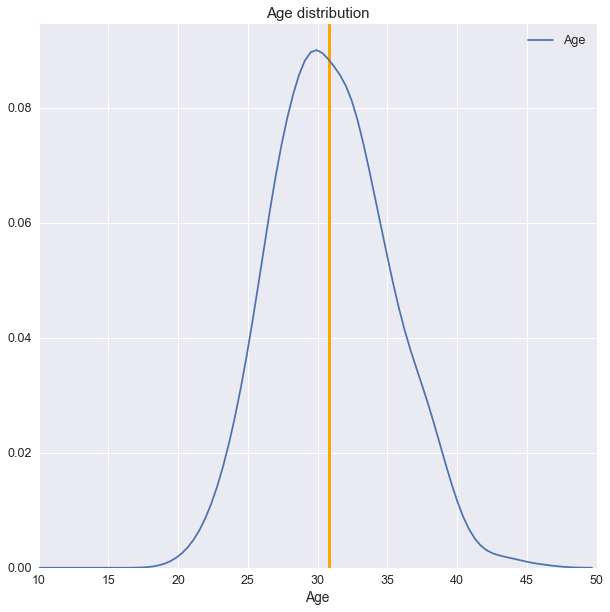

In [151]:
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis 
sns.set_style("whitegrid")
plt.xlim(10,50)
plt.axvline(x=30.825117,color='orange',linewidth=3)
sns.kdeplot(fighterdf['Age'], ax = ax)
ax.set_title('Age distribution') # Give the plot a main title
ax.set_xlabel('Age') # Set text for the x axis

Text(0.5,0,'Height')

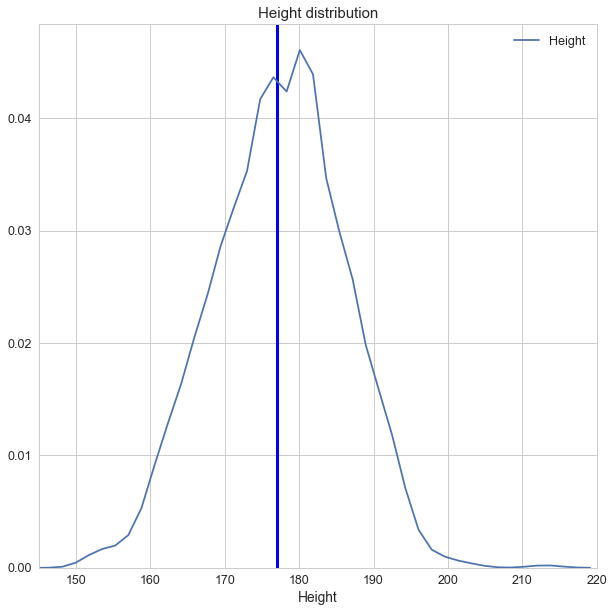

In [158]:
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis 
sns.set_style("whitegrid")
plt.axvline(x=177.066901,color='blue',linewidth=3)
plt.xlim(145,220)
sns.kdeplot(fighterdf['Height'], ax = ax)
ax.set_title('Height distribution') # Give the plot a main title
ax.set_xlabel('Height') # Set text for the x axis

Text(0.5,0,'Weight')

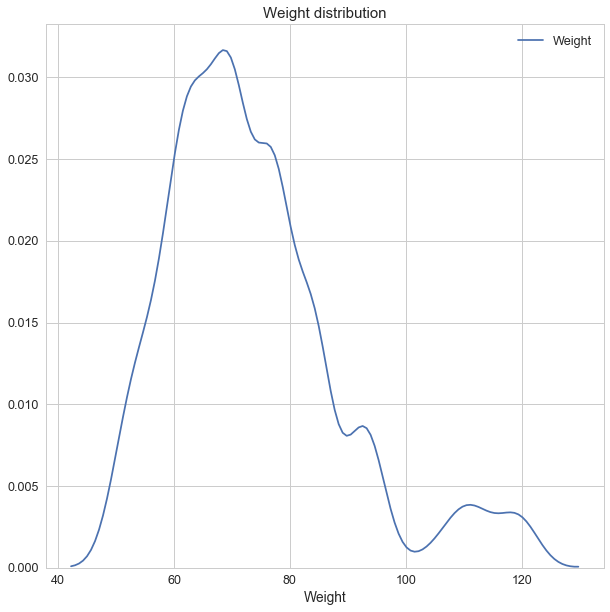

In [168]:
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis 
sns.set_style("whitegrid")
sns.kdeplot(fighterdf['Weight'], ax = ax)
ax.set_title('Weight distribution') # Give the plot a main title
ax.set_xlabel('Weight') # Set text for the x axis

## Aggregated Data

In [35]:
df.head()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
0,1,1,23.0,182.0,Trento Italy,2783,Mezzocorona Italy,Marvin Vettori,84,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red
1,0,0,32.0,175.0,"Careiro da Várzea, Amazonas Brazil",2208,"Pharr, Texas USA",Carlos Diego Ferreira,70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,blue
2,2,0,38.0,172.0,Kanagawa Japan,721,Tokyo Japan,Takanori Gomi,70,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KO/TKO,red
3,0,0,23.0,170.0,Tijuana Mexico,2825,Tijuana Mexico,Brandon Moreno,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,blue
4,3,1,30.0,167.0,"Spokane, WA USA",2260,"Spokane, WA USA",Elizabeth Phillips,61,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red


In [36]:
df.describe()

,BPrev,BStreak,B_Age,B_Height,B_ID,B_Weight,B__Round1_Grappling_Reversals_Landed,B__Round1_Grappling_Standups_Landed,B__Round1_Grappling_Submissions_Attempts,B__Round1_Grappling_Takedowns_Attempts,...,R__Round5_TIP_Distance Time,R__Round5_TIP_Ground Control Time,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time
count,1477.000000,1477.000000,1474.000000,1476.000000,1477.000000,1477.000000,978.000000,978.000000,978.000000,978.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.735274,0.654705,30.954545,177.451220,1964.633040,73.804333,0.036810,0.896728,0.431493,2.986708,...,211.965278,34.062500,66.604167,5.527778,4.319444,5.138889,12.097222,224.965278,4.562500,263.069444
std,1.895561,1.057269,4.020311,8.561541,666.949141,14.980531,0.193748,1.255722,0.830527,3.987291,...,139.412374,68.819742,94.574736,22.374419,12.854023,14.312013,36.429320,142.328509,19.698681,162.386212
min,0.000000,0.000000,20.000000,152.000000,129.000000,52.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,28.000000,172.000000,1755.000000,65.000000,0.000000,0.000000,0.000000,0.000000,...,110.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,126.750000,0.000000,139.000000
50%,1.000000,0.000000,31.000000,177.000000,2156.000000,70.000000,0.000000,0.000000,0.000000,2.000000,...,214.000000,0.000000,9.500000,0.000000,0.000000,0.000000,0.000000,232.000000,0.000000,291.000000
75%,3.000000,1.000000,34.000000,182.000000,2337.000000,84.000000,0.000000,1.000000,1.000000,4.000000,...,294.500000,47.500000,109.000000,0.000000,0.000000,0.000000,2.000000,299.000000,0.000000,300.000000
max,11.000000,7.000000,46.000000,213.000000,2882.000000,120.000000,2.000000,9.000000,6.000000,33.000000,...,647.000000,496.000000,529.000000,144.000000,91.000000,62.000000,264.000000,659.000000,128.000000,841.000000


In [37]:
df.describe(include=['O'])

,B_HomeTown,B_Location,B_Name,Date,R_HomeTown,R_Location,R_Name,winby,winner
count,1471,1470,1477,1477,1477,1476,1477,1461,1477
unique,568,431,719,224,495,390,633,3,4
top,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Tim Means,12/14/2015,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Donald Cerrone,DEC,red
freq,32,38,8,32,44,67,11,720,867


In [38]:
ndf = df
ndf.fillna(0, inplace=True)

In [39]:
temp_b = ndf.columns.tolist()[9:98]
blue = []
red = []
for i in temp_b:
    blue.append('B_' + i[10:])
    red.append('R_' + i[10:])
    
blue_info = ndf.columns.tolist()[0:9]
red_info = ndf.columns.tolist()[449:458] 
fight_info = ndf.columns.tolist()[444:449] + ndf.columns.tolist()[893:]
new_df_columns = fight_info + blue_info + red_info + blue + red
print(len(new_df_columns))

203


In [40]:
def filter_round(label):
    team = ''
    new_label = ''
    if len(label) > 9 and (label[:8] == 'B__Round' or label[:8] == 'R__Round'):
        team = label[0]
        new_label = label[10:]
        return team + '_'+new_label
    return None

In [41]:
aggregate_df = pd.DataFrame()

for idx, i in ndf.iterrows():
#     print(idx)
    blue_dct = dict.fromkeys(blue,0)
    red_dct = dict.fromkeys(red,0)
    temp_dct = dict()
    for j in ndf.columns:
        lbl = filter_round(j)
        if (lbl == None):
            temp_dct[j] = i[j]
        else:
            if (lbl[0] == 'B'):
                blue_dct[lbl] = blue_dct.get(lbl, 0) + i[j]
            elif (lbl[0] == 'R'):
                red_dct[lbl] = red_dct.get(lbl, 0) + i[j]
        blue_dct[lbl] = blue_dct.get(lbl, 0)/i['Last_round']
        red_dct[lbl] = red_dct.get(lbl, 0)/i['Last_round']
    temp_dct.update(blue_dct)
    temp_dct.update(red_dct)
    aggregate_df[idx] = pd.Series(temp_dct)

In [169]:
aggregate_df = aggregate_df.T
aggregate_df.head()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,Date,...,R_TIP_Distance Time,R_TIP_Ground Control Time,R_TIP_Ground Time,R_TIP_Guard Control Time,R_TIP_Half Guard Control Time,R_TIP_Misc. Ground Control Time,R_TIP_Mount Control Time,R_TIP_Neutral Time,R_TIP_Side Control Time,R_TIP_Standing Time
0,1,1,23,182,Trento Italy,2783,Mezzocorona Italy,Marvin Vettori,84,01/02/2017,...,14.9794,31.2222,46.5391,1.42798,6.2716,0,10.7078,17.5638,0.962963,26.6831
1,0,0,32,175,"Careiro da Várzea, Amazonas Brazil",2208,"Pharr, Texas USA",Carlos Diego Ferreira,70,06/30/2014,...,0,0,0,0,0,0,0,0,0,0
2,2,0,38,172,Kanagawa Japan,721,Tokyo Japan,Takanori Gomi,70,07/27/2015,...,618,105,162,0,0,19,0,676,0,790
3,0,0,23,170,Tijuana Mexico,2825,Tijuana Mexico,Brandon Moreno,56,10/03/2016,...,1431,1644,2437,311,379,0,544,1601,152,2069
4,3,1,30,167,"Spokane, WA USA",2260,"Spokane, WA USA",Elizabeth Phillips,61,08/22/2016,...,34.6132,2.13169,3.68724,0.716049,0.148148,0.625514,0.493827,39.8519,0,50.5103


In [170]:
aggregate_df.fillna(0,inplace=True)
aggregate_df.to_csv('out.csv')

In [171]:
# aggregate_df = pd.DataFrame.from_csv('out.csv')

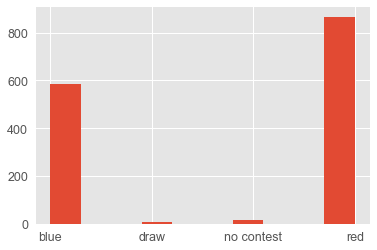

In [172]:
aggregate_df['winner'].hist()

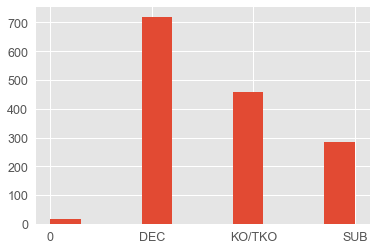

In [173]:
aggregate_df['winby'].hist()

In [178]:
dropdata = aggregate_df.drop(['B_ID','B_Name','R_ID','R_Name','winby','Date','Last_round','Max_round'],axis=1)
dropdata.rename(columns={'BPrev':'B__Prev',
                         'RPrev':'R__Prev',
                         'B_Age':'B__Age',
                         'B_Height':'B__Height',
                         'B_Weight':'B__Weight',
                         'R_Age':'R__Age',
                         'R_Height':'R__Height',
                         'R_Weight':'R__Weight',
                         'BStreak':'B__Streak',
                         'RStreak': 'R__Streak'},inplace=True)
dropdata.describe()

,B__Prev,B__Streak,B__Age,B__Height,B__Weight,Event_ID,Fight_ID,R__Prev,R__Streak,R__Age,...,R_TIP_Distance Time,R_TIP_Ground Control Time,R_TIP_Ground Time,R_TIP_Guard Control Time,R_TIP_Half Guard Control Time,R_TIP_Misc. Ground Control Time,R_TIP_Mount Control Time,R_TIP_Neutral Time,R_TIP_Side Control Time,R_TIP_Standing Time
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,...,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,1.735274,0.654705,30.891672,177.331077,73.804333,733.943805,5583.656060,2.125254,0.721733,31.358835,...,180.909365,54.928462,100.258080,12.938840,11.697329,4.547147,14.556669,189.378421,4.170105,232.804877
std,1.895561,1.057269,4.251308,9.724703,14.980531,50.851452,611.609705,1.979199,1.136555,4.178100,...,484.779639,188.381967,296.888901,54.106976,51.187665,19.933460,58.164258,503.299873,20.507036,606.636259
min,0.000000,0.000000,0.000000,0.000000,52.000000,646.000000,4521.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,28.000000,172.000000,65.000000,687.000000,5016.000000,1.000000,0.000000,28.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,31.000000,177.000000,70.000000,738.000000,5580.000000,2.000000,0.000000,31.000000,...,11.551440,1.468750,6.000000,0.000000,0.000000,0.000000,0.144033,12.370370,0.000000,15.724280
75%,3.000000,1.000000,34.000000,182.000000,84.000000,780.000000,6142.000000,3.000000,1.000000,34.000000,...,80.814815,13.000000,29.812500,1.864198,1.123457,0.144033,2.942387,83.840820,0.135802,104.593750
max,11.000000,7.000000,46.000000,213.000000,120.000000,816.000000,6627.000000,12.000000,9.000000,46.000000,...,5322.000000,2463.000000,3947.000000,652.000000,529.000000,255.000000,1135.000000,5426.000000,270.000000,6122.000000


In [179]:
objecttypes = list(dropdata.select_dtypes(include=['O']).columns)
for col in objecttypes:
    dropdata[col] = dropdata[col].astype('category')

In [64]:
cat_columns = dropdata.select_dtypes(['category']).columns
dropdata[cat_columns] = dropdata[cat_columns].apply(lambda x: x.cat.codes)
dropdata.info()
# dropdata.tail()

NameError: name 'dropdata' is not defined

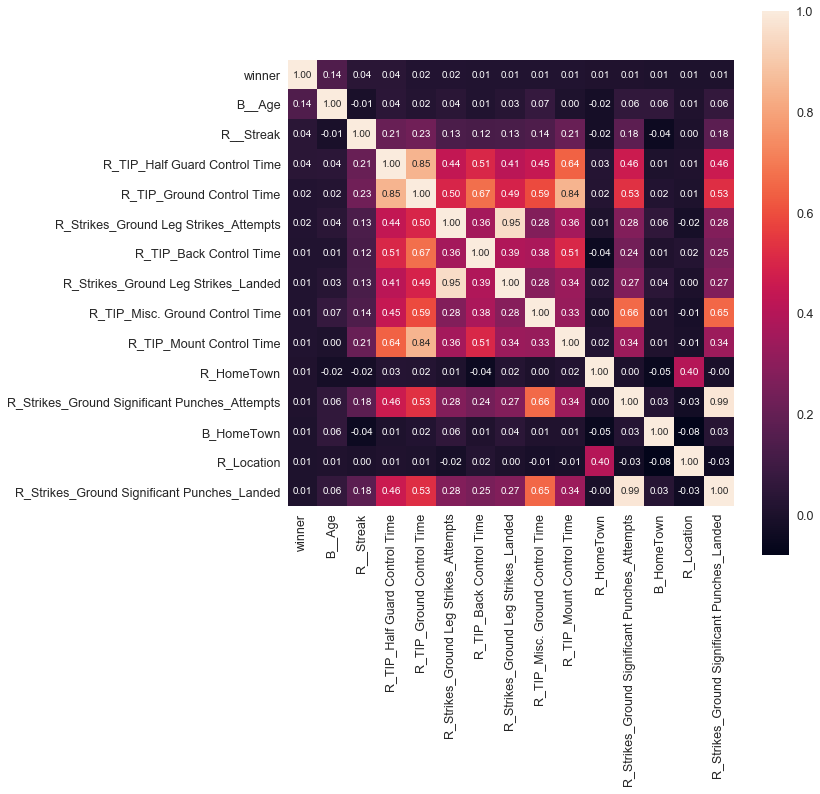

In [183]:
# Subset Correlation Matrix
k = 15 #number of variables for heatmap
corrmat = dropdata.corr()
cols = corrmat.nlargest(k, 'winner')['winner'].index
cm = np.corrcoef(dropdata[cols].values.T)
fig, ax = plt.subplots(figsize=(10,10))  
sb.set(font_scale=1.25)
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()